In [86]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import time

# 2. Logistic regressions


## 2.1. Loading saved train/test data

In [118]:
X_train_unigram = pickle.load(open("savedData/X_train_unigram","rb"))
X_test_unigram = pickle.load(open("savedData/X_test_unigram","rb"))
unigram_features = pickle.load(open("savedData/unigram_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_unigram.shape))
print('shape of X_test_bow is {}'.format(X_test_unigram.shape))

shape of X_train_bow is (70000, 78273)
shape of X_test_bow is (30000, 78273)


In [119]:
X_train_bigram = pickle.load(open("savedData/X_train_bigram","rb"))
X_test_bigram = pickle.load(open("savedData/X_test_bigram","rb"))
bigram_features = pickle.load(open("savedData/bigram_features","rb")).tolist()
print('shape of X_train_bigram is {}'.format(X_train_bigram.shape))
print('shape of X_test_bigram is {}'.format(X_test_bigram.shape))

shape of X_train_bigram is (70000, 1130946)
shape of X_test_bigram is (30000, 1130946)


In [150]:
X_train_tfidf = pickle.load(open("savedData/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("savedData/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("savedData/tfidf_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_tfidf.shape))
print('shape of X_test_bow is {}'.format(X_test_tfidf.shape))

shape of X_train_bow is (70000, 78006)
shape of X_test_bow is (30000, 78006)


In [121]:
w2v_words = pickle.load(open("savedData/w2v_words","rb")).tolist()
X_train_avgw2v = pickle.load(open("savedData/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("savedData/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)


In [122]:
y_train = np.load('savedData/y_train.npy',allow_pickle=True)
y_test = np.load('savedData/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of y_train is (70000,)
shape of y_test is (30000,)


## 2.2. Logistic regression on unigram features 


### Finding the optimal regularization parameter C using grid search

In [166]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]
t=time.time()
grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_unigram,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 4116.148409128189 seconds.


In [167]:
best_params_unigram = model.best_params_
print(best_params_unigram)


{'C': 0.1, 'penalty': 'l2'}


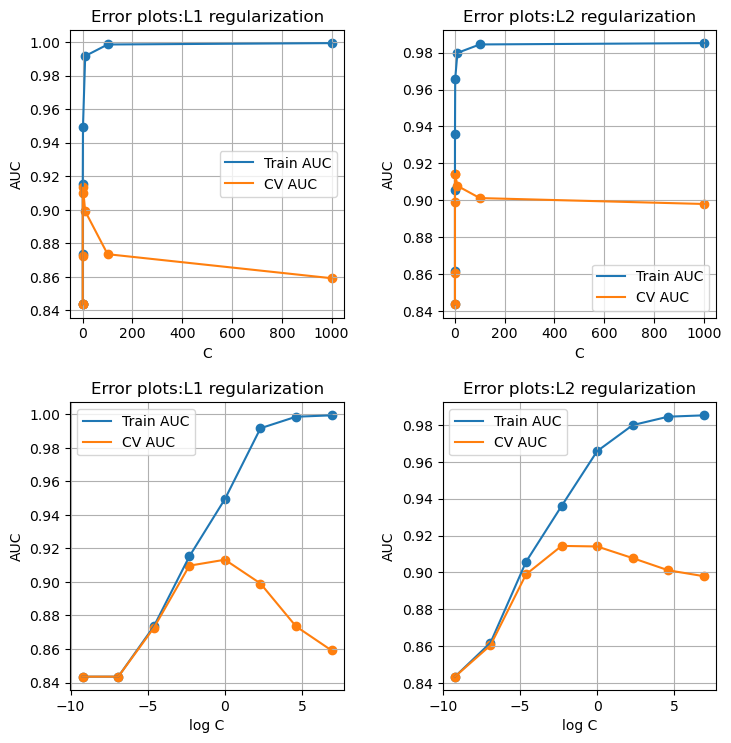

In [168]:
fig, axes = plt.subplots(2,2,figsize = (8,8))
plt.tight_layout(pad=4)
for i in range(2):   
    train_auc_unigram = model.cv_results_['mean_train_score'][0+i:len(C)*2+i:2]
    cv_auc_unigram = model.cv_results_['mean_test_score'][0+i:len(C)*2+i:2]
    axes[0,i].plot(C,train_auc_unigram, label='Train AUC')
    axes[0,i].plot(C, cv_auc_unigram, label='CV AUC')
    axes[0,i].scatter(C, train_auc_unigram)
    axes[0,i].grid(True)
    axes[0,i].legend()
    axes[0,i].scatter(C, cv_auc_unigram)
    axes[0,i].set_xlabel('C')
    axes[0,i].set_ylabel("AUC")
    axes[0,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')
    
    axes[1,i].plot(np.log(C), train_auc_unigram, label='Train AUC')
    axes[1,i].plot(np.log(C), cv_auc_unigram, label='CV AUC')
    axes[1,i].scatter(np.log(C), train_auc_unigram)
    axes[1,i].grid(True)
    axes[1,i].legend()
    axes[1,i].scatter(np.log(C), cv_auc_unigram)
    axes[1,i].set_xlabel('log C')
    axes[1,i].set_ylabel("AUC")
    axes[1,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')

plt.show()

In [169]:
model_opt_unigram = LogisticRegression(**best_params_unigram,solver='liblinear')
model_opt_unigram.fit(X_train_unigram,y_train)

y_pred = model_opt_unigram.predict(X_test_unigram)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_unigram.predict_proba(X_train_unigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_unigram.predict_proba(X_test_unigram)[:,1])

auc_train_unigram = auc(train_fpr, train_tpr)
auc_test_unigram  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_unigram}\n")
print(F"Test AUC = {auc_test_unigram}\n")


Train AUC = 0.9656250263870763

Test AUC = 0.9338481393369358



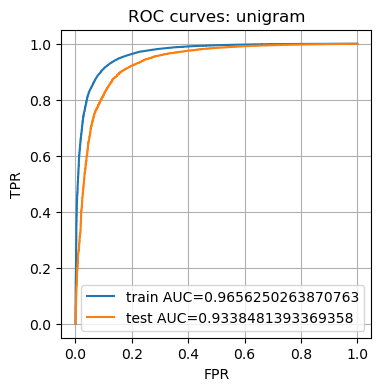

In [171]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_unigram))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_unigram))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: unigram')
plt.show()


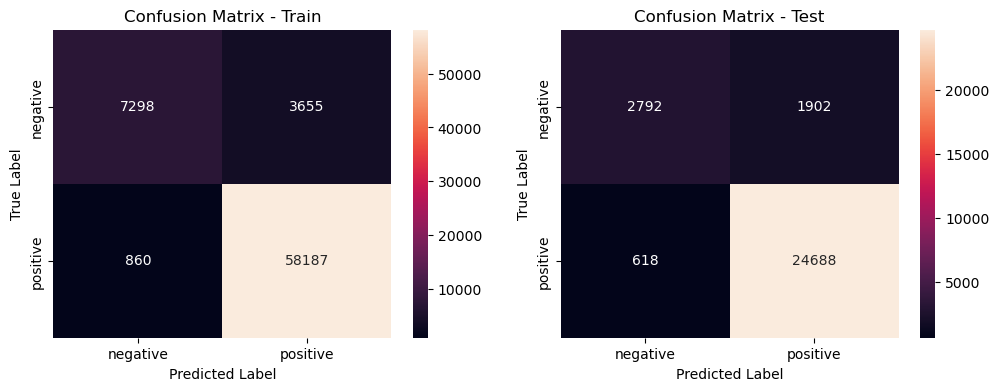

In [172]:
plot_confusion_matrixes(model_opt_unigram,X_train_unigram,y_train,X_test_unigram,y_test)

In [173]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
        df = df_train if i==0 else df_test
        sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
        axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")
    plt.show()


In [175]:
data_l2 = model_opt_unigram.coef_.reshape(-1,1)
datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=unigram_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                 coef
worst      -1.883933
threw      -1.561149
disappoint -1.535339
horribl    -1.476448
terribl    -1.440713
cancel     -1.388025
disgust    -1.377769
unfortun   -1.307089
bland      -1.285962
return     -1.263100
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                 coef
perfect     1.543130
delici      1.515132
highli      1.332000
awesom      1.327721
excel       1.320006
best        1.238885
great       1.110825
yummi       1.110255
pleasantli  1.083954
uniqu       1.055314


## 2.3. Logistic regression on bigram features

In [231]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]
t=time.time()
grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_bigram,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 451.75962376594543 seconds.


In [232]:
X_train_bigram.shape

(70000, 1130946)

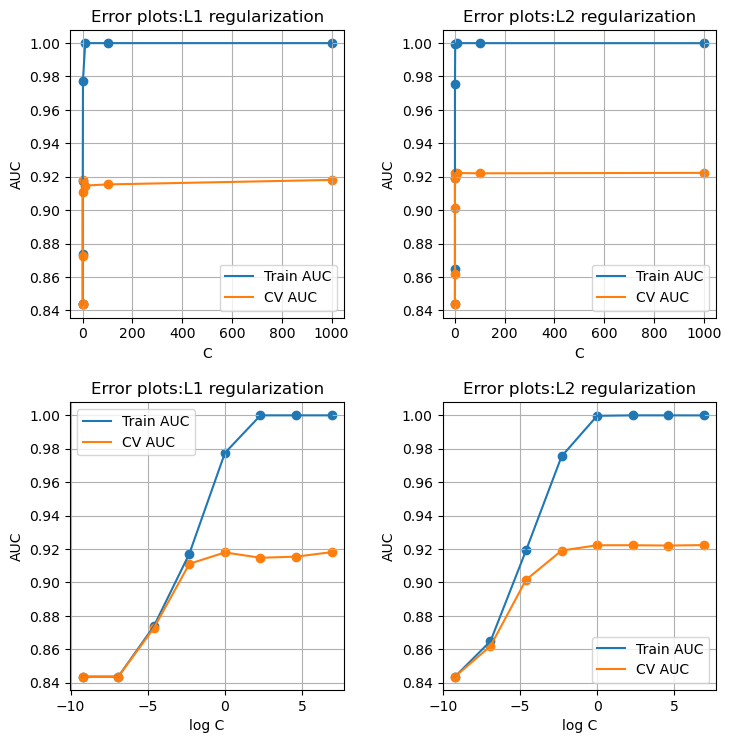

In [243]:
fig, axes = plt.subplots(2,2,figsize = (8,8))
plt.tight_layout(pad=4)
for i in range(2):   
    train_auc_bigram = model.cv_results_['mean_train_score'][0+i:len(C)*2+i:2]
    cv_auc_bigram = model.cv_results_['mean_test_score'][0+i:len(C)*2+i:2]
    axes[0,i].plot(C,train_auc_bigram, label='Train AUC')
    axes[0,i].plot(C, cv_auc_bigram, label='CV AUC')
    axes[0,i].scatter(C, train_auc_bigram)
    axes[0,i].grid(True)
    axes[0,i].legend()
    axes[0,i].scatter(C, cv_auc_bigram)
    axes[0,i].set_xlabel('C')
    axes[0,i].set_ylabel("AUC")
    axes[0,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')
    
    axes[1,i].plot(np.log(C), train_auc_bigram, label='Train AUC')
    axes[1,i].plot(np.log(C), cv_auc_bigram, label='CV AUC')
    axes[1,i].scatter(np.log(C), train_auc_bigram)
    axes[1,i].grid(True)
    axes[1,i].legend()
    axes[1,i].scatter(np.log(C), cv_auc_bigram)
    axes[1,i].set_xlabel('log C')
    axes[1,i].set_ylabel("AUC")
    axes[1,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')

plt.show()

In [244]:
best_params_bigram = model.best_params_
print(best_params_bigram)

{'C': 1000, 'penalty': 'l2'}


In [236]:
model_opt_bigram = LogisticRegression(**best_params_bigram)
model_opt_bigram.fit(X_train_bigram,y_train)

y_pred = model_opt_bigram.predict(X_test_bigram)

In [237]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_bigram.predict_proba(X_train_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_bigram.predict_proba(X_test_bigram)[:,1])

auc_train_bigram= auc(train_fpr, train_tpr)
auc_test_bigram  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_bigram}\n")
print(F"Test AUC = {auc_test_bigram}\n")

Train AUC = 0.9999999953613636

Test AUC = 0.932503414280784



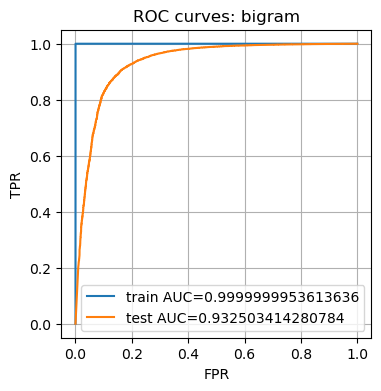

In [238]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc(test_fpr, test_tpr)))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: bigram')
plt.show()

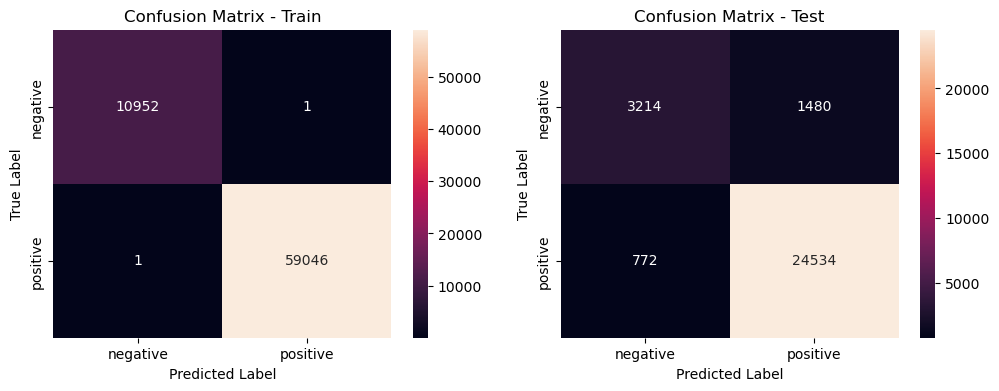

In [239]:
plot_confusion_matrixes(model_opt_bigram,X_train_bigram,y_train,X_test_bigram,y_test)

In [194]:
data_l2 = model_opt_bigram.coef_.reshape(-1,1)
datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=bigram_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative)) 
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                 coef
worst     -14.945894
threw     -11.724395
disgust   -10.935197
tasteless -10.929446
two star  -10.449498
unpleas   -10.093861
horribl   -10.082453
yuck       -9.545230
terribl    -9.515408
cancel     -9.328763
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                        coef
awesom            10.378859
uniqu             10.121102
hook               8.977102
beat               8.889871
pleasantli         8.799706
highli recommend   8.718206
worri              8.630916
perfectli          8.594289
perfect            8.358013
fantast            8.293177


## 2.4. Logistic regression on TFIDF features

In [151]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]
t=time.time()
grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_tfidf,y_train)
G
Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 87.34718370437622 seconds.


{'C': 1, 'penalty': 'l1'}


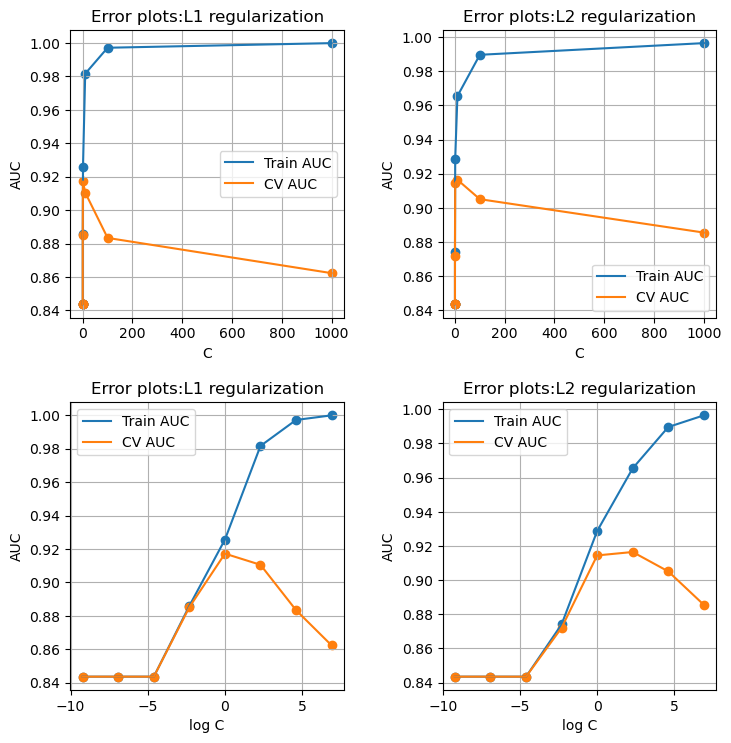

In [152]:
best_params_tfidf = model.best_params_
print(best_params_tfidf)


fig, axes = plt.subplots(2,2,figsize = (8,8))
plt.tight_layout(pad=4)
for i in range(2):   
    train_auc_tfidf = model.cv_results_['mean_train_score'][0+i:len(C)*2+i:2]
    cv_auc_tfidf = model.cv_results_['mean_test_score'][0+i:len(C)*2+i:2]
    axes[0,i].plot(C,train_auc_tfidf, label='Train AUC')
    axes[0,i].plot(C, cv_auc_tfidf, label='CV AUC')
    axes[0,i].scatter(C, train_auc_tfidf)
    axes[0,i].grid(True)
    axes[0,i].legend()
    axes[0,i].scatter(C, cv_auc_tfidf)
    axes[0,i].set_xlabel('C')
    axes[0,i].set_ylabel("AUC")
    axes[0,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')
    
    axes[1,i].plot(np.log(C), train_auc_tfidf, label='Train AUC')
    axes[1,i].plot(np.log(C), cv_auc_tfidf, label='CV AUC')
    axes[1,i].scatter(np.log(C), train_auc_tfidf)
    axes[1,i].grid(True)
    axes[1,i].legend()
    axes[1,i].scatter(np.log(C), cv_auc_tfidf)
    axes[1,i].set_xlabel('log C')
    axes[1,i].set_ylabel("AUC")
    axes[1,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')

plt.show()

In [162]:
best_params_tfidf

{'C': 1, 'penalty': 'l1'}

In [179]:
model_opt_tfidf = LogisticRegression(**best_params_tfidf,solver='liblinear')
model_opt_tfidf.fit(X_train_tfidf,y_train)

y_pred = model_opt_tfidf.predict(X_test_tfidf)

In [180]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_tfidf.predict_proba(X_test_tfidf)[:,1])

auc_train_tfidf = auc(train_fpr, train_tpr)
auc_test_tfidf  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_tfidf}\n")
print(F"Test AUC = {auc_test_tfidf}\n")

Train AUC = 0.9537621862138177

Test AUC = 0.9429925054360617



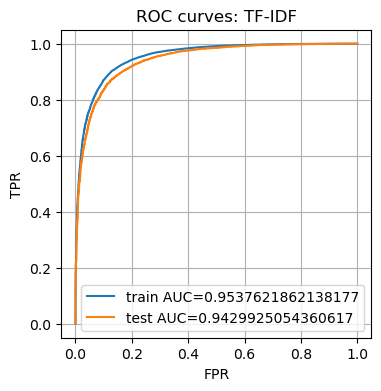

In [181]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_tfidf))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_tfidf))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: TF-IDF')
plt.show()

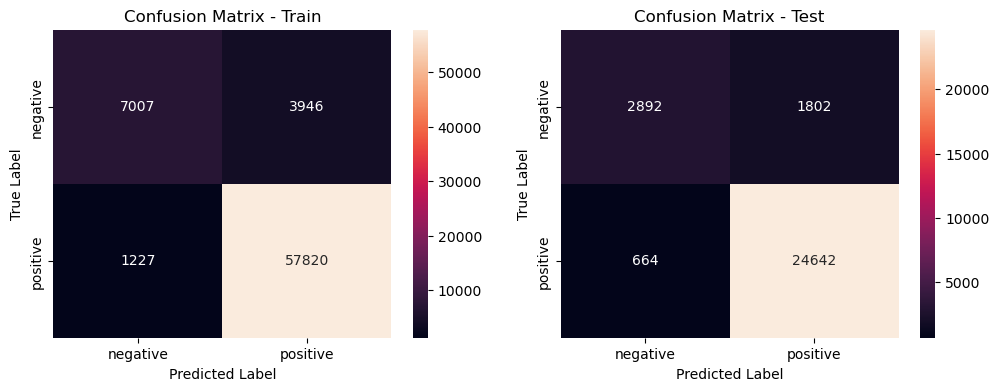

In [182]:
plot_confusion_matrixes(model_opt_tfidf,X_train_tfidf,y_train,X_test_tfidf,y_test)

In [183]:
data_l2 = model_opt_tfidf.coef_.reshape(-1,1)
datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=tfidf_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative)) 
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                  coef
worst      -15.200477
disappoint -10.718786
threw       -9.946314
horribl     -9.909157
terribl     -9.840287
refund      -9.312800
disgust     -8.959528
aw          -8.759218
return      -8.233315
decept      -8.020899
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                  coef
great       14.181346
perfect     13.551929
best        13.212876
delici      12.816103
pleasantli  11.924718
excel       11.104272
highli      10.903080
love        10.764873
awesom      10.752782
amaz         9.688210


## 2.5 Logistic regression on word2vec features 

In [137]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]
t=time.time()
grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_avgw2v,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")



The elapsed time is 94.05192017555237 seconds.


In [139]:
best_params_avgw2v = model.best_params_
print(best_params_avg_w2v)

{'C': 1, 'penalty': 'l1'}


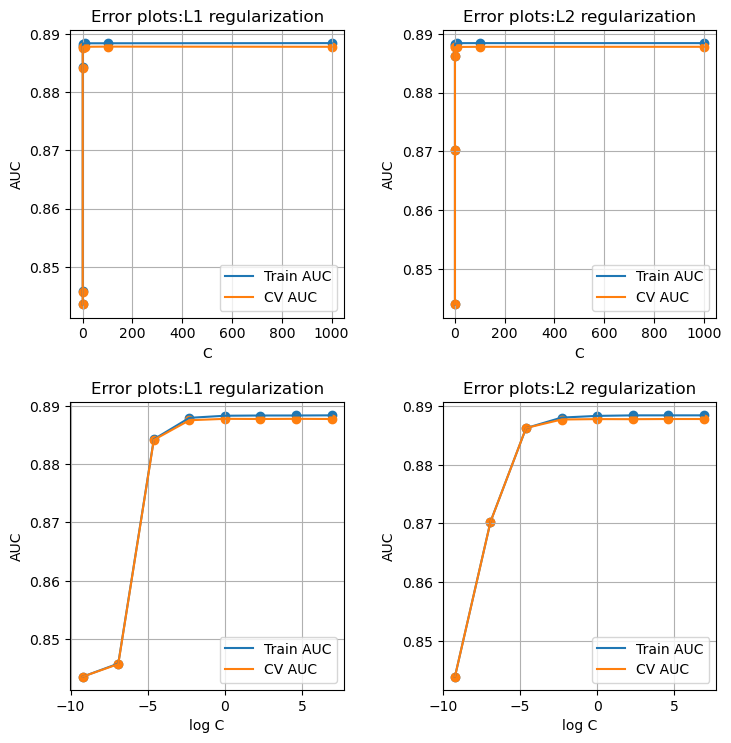

In [142]:
fig, axes = plt.subplots(2,2,figsize = (8,8))
plt.tight_layout(pad=4)
for i in range(2):   
    train_auc_avgw2v= model.cv_results_['mean_train_score'][0+i:len(C)*2+i:2]
    cv_auc_avgw2v = model.cv_results_['mean_test_score'][0+i:len(C)*2+i:2]
    axes[0,i].plot(C,train_auc_avgw2v,label='Train AUC')
    axes[0,i].plot(C, cv_auc_avgw2v, label='CV AUC')
    axes[0,i].scatter(C, train_auc_avgw2v)
    axes[0,i].grid(True)
    axes[0,i].legend()
    axes[0,i].scatter(C, cv_auc_avgw2v)
    axes[0,i].set_xlabel('C')
    axes[0,i].set_ylabel("AUC")
    axes[0,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')
    
    axes[1,i].plot(np.log(C), train_auc_avgw2v, label='Train AUC')
    axes[1,i].plot(np.log(C), cv_auc_avgw2v, label='CV AUC')
    axes[1,i].scatter(np.log(C), train_auc_avgw2v)
    axes[1,i].grid(True)
    axes[1,i].legend()
    axes[1,i].scatter(np.log(C), cv_auc_avgw2v)
    axes[1,i].set_xlabel('log C')
    axes[1,i].set_ylabel("AUC")
    axes[1,i].set_title("Error plots:" + penalty[i].capitalize() + ' regularization')

plt.show()

In [145]:
model_opt_avgw2v = LogisticRegression(**best_params_avgw2v,solver='liblinear')
model_opt_avgw2v.fit(X_train_avgw2v,y_train)

y_pred_avgw2v = model_opt_avgw2v.predict(X_test_avgw2v)


train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_avgw2v.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_avgw2v.predict_proba(X_test_avgw2v)[:,1])

auc_train_avg_w2v = auc(train_fpr, train_tpr)
auc_test_avg_w2v = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_avg_w2v}\n")
print(F"Test AUC = {auc_test_avg_w2v}\n")

Train AUC = 0.8995396495106036

Test AUC = 0.9029144372160429



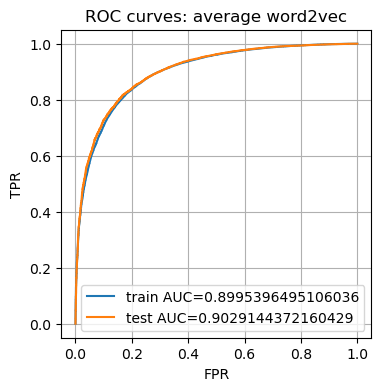

In [146]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_avg_w2v))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_avg_w2v))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: average word2vec')
plt.show()


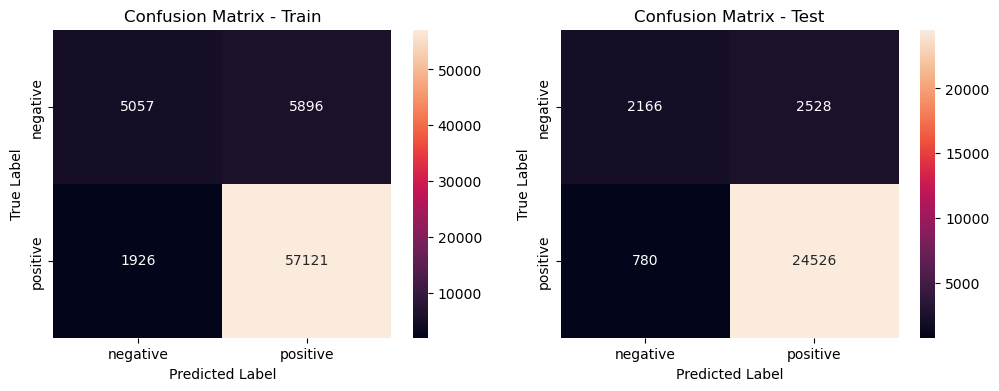

In [147]:
plot_confusion_matrixes(model_opt_avgw2v,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

## 2.6. Model evaluation 

The hyperparameter tuning results and the train/test AUCs are given below for different word vectorization methods. The model with the TF-IDF features have the best performance without overfitting. The unigram and bigram models are overfitting. The average word2vec model is not overfitting but has the lowest accuracy. 



In [240]:
# import module
from tabulate import tabulate
 
# assign data
tb = [['unigram',best_params_unigram['penalty'],best_params_unigram['C'],auc_train_unigram,auc_test_unigram],
     ['bigram',best_params_bigram['penalty'],best_params_bigram['C'],auc_train_bigram,auc_test_bigram],
     ['TF-IDF',best_params_tfidf['penalty'],best_params_tfidf['C'],auc_train_tfidf,auc_test_tfidf],
     ['avg w2v',best_params_avgw2v['penalty'],best_params_avgw2v['C'],auc_train_avg_w2v,auc_test_avg_w2v]]
 
# create header
head =  ["Vector","regulariation", "Hyperparameter-C", "Train AUC", "Test AUC"]
 
# display table
print(tabulate(tb, headers=head, tablefmt="github"))

| Vector   | regulariation   |   Hyperparameter-C |   Train AUC |   Test AUC |
|----------|-----------------|--------------------|-------------|------------|
| unigram  | l2              |                0.1 |    0.965625 |   0.933848 |
| bigram   | l2              |             1000   |    1        |   0.932503 |
| TF-IDF   | l1              |                1   |    0.953762 |   0.942993 |
| avg w2v  | l1              |                1   |    0.89954  |   0.902914 |
